# Variational Autoencoder (VAE) Implementation on MNIST
Implementation of a Variational Autoencoder for generative modeling and latent space exploration.


## 1. Setup & Imports <a id='setup'></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Data Loading <a id='data'></a>

We'll use the MNIST dataset with standard normalization.

In [2]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20
latent_dim = 20

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.88MB/s]

Training samples: 60000
Test samples: 10000


### Visualize Sample Data

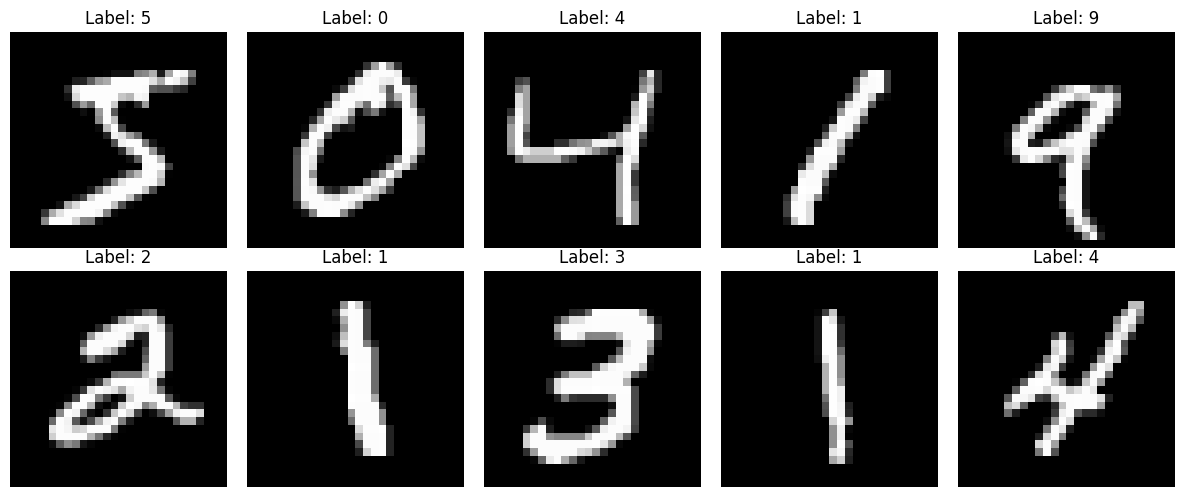

In [3]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Model Architecture <a id='model'></a>

The VAE consists of:
- **Encoder**: Maps input to latent distribution parameters (μ, σ)
- **Reparameterization**: Samples from latent distribution using reparameterization trick
- **Decoder**: Generates reconstruction from latent sample

**Loss Function**: Reconstruction Loss (BCE) + KL Divergence

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)

        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        reconstructed = torch.sigmoid(self.fc5(h))
        return reconstructed

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

# Initialize model
model = VAE(latent_dim=latent_dim).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal parameters: {total_params:,}')

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)

Total parameters: 1,082,680


### Loss Function

VAE loss = Reconstruction Loss + KL Divergence

The reconstruction loss measures how well the decoder reconstructs the input, while the KL divergence regularizes the latent space to follow a standard normal distribution.

In [5]:
def vae_loss(reconstructed, original, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div, recon_loss, kl_div

## 4. Training <a id='training'></a>

In [6]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training history
train_losses = []
test_losses = []
recon_losses = []
kl_losses = []

In [7]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0

    for images, _ in tqdm(loader, desc='Training', leave=False):
        images = images.view(-1, 784).to(device)

        # Forward pass
        reconstructed, mu, logvar = model(images)
        loss, recon, kl = vae_loss(reconstructed, images, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_recon += recon.item()
        running_kl += kl.item()

    n_samples = len(loader.dataset)
    return running_loss / n_samples, running_recon / n_samples, running_kl / n_samples

def evaluate(model, loader, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, _ in loader:
            images = images.view(-1, 784).to(device)
            reconstructed, mu, logvar = model(images)
            loss, _, _ = vae_loss(reconstructed, images, mu, logvar)
            running_loss += loss.item()

    return running_loss / len(loader.dataset)

In [8]:
# Training loop
print('Starting training...\n')

for epoch in range(num_epochs):
    train_loss, recon_loss, kl_loss = train_epoch(model, train_loader, optimizer, device)
    test_loss = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    recon_losses.append(recon_loss)
    kl_losses.append(kl_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Recon: {recon_loss:.4f}, KL: {kl_loss:.4f}')

print('\nTraining completed!')

Starting training...



Epoch [1/20] - Train Loss: 173.5690, Test Loss: 135.4169, Recon: 165.0807, KL: 8.4882


Epoch [2/20] - Train Loss: 126.1979, Test Loss: 118.8387, Recon: 110.7767, KL: 15.4212


Epoch [3/20] - Train Loss: 116.4967, Test Loss: 112.8645, Recon: 99.6635, KL: 16.8332


Epoch [4/20] - Train Loss: 111.8419, Test Loss: 109.4040, Recon: 94.0287, KL: 17.8132


Epoch [5/20] - Train Loss: 109.1673, Test Loss: 107.6897, Recon: 90.8739, KL: 18.2935


Epoch [6/20] - Train Loss: 107.3728, Test Loss: 106.2149, Recon: 88.7865, KL: 18.5863


Epoch [7/20] - Train Loss: 106.1087, Test Loss: 105.3112, Recon: 87.3590, KL: 18.7497


Epoch [8/20] - Train Loss: 105.0749, Test Loss: 104.4831, Recon: 86.1835, KL: 18.8914


Epoch [9/20] - Train Loss: 104.3236, Test Loss: 103.6563, Recon: 85.2871, KL: 19.0365


Epoch [10/20] - Train Loss: 103.6779, Test Loss: 103.3017, Recon: 84.5397, KL: 19.1381


Epoch [11/20] - Train Loss: 102.9898, Test Loss: 103.5427, Recon: 83.7851, KL: 19.2047


Epoch [12/20] - Train Loss: 102.5029, Test Loss: 102.4394, Recon: 83.2129, KL: 19.2900


Epoch [13/20] - Train Loss: 102.0935, Test Loss: 102.2535, Recon: 82.7441, KL: 19.3494


Epoch [14/20] - Train Loss: 101.7111, Test Loss: 102.1571, Recon: 82.3319, KL: 19.3793


Epoch [15/20] - Train Loss: 101.3423, Test Loss: 101.7418, Recon: 81.9103, KL: 19.4320


Epoch [16/20] - Train Loss: 101.0607, Test Loss: 101.6529, Recon: 81.5824, KL: 19.4783


Epoch [17/20] - Train Loss: 100.7576, Test Loss: 101.4641, Recon: 81.2403, KL: 19.5172


Epoch [18/20] - Train Loss: 100.5010, Test Loss: 100.9418, Recon: 80.9345, KL: 19.5665


Epoch [19/20] - Train Loss: 100.2744, Test Loss: 101.4923, Recon: 80.6716, KL: 19.6029


Epoch [20/20] - Train Loss: 100.0505, Test Loss: 100.9300, Recon: 80.4403, KL: 19.6102

Training completed!


### Plot Training Curves

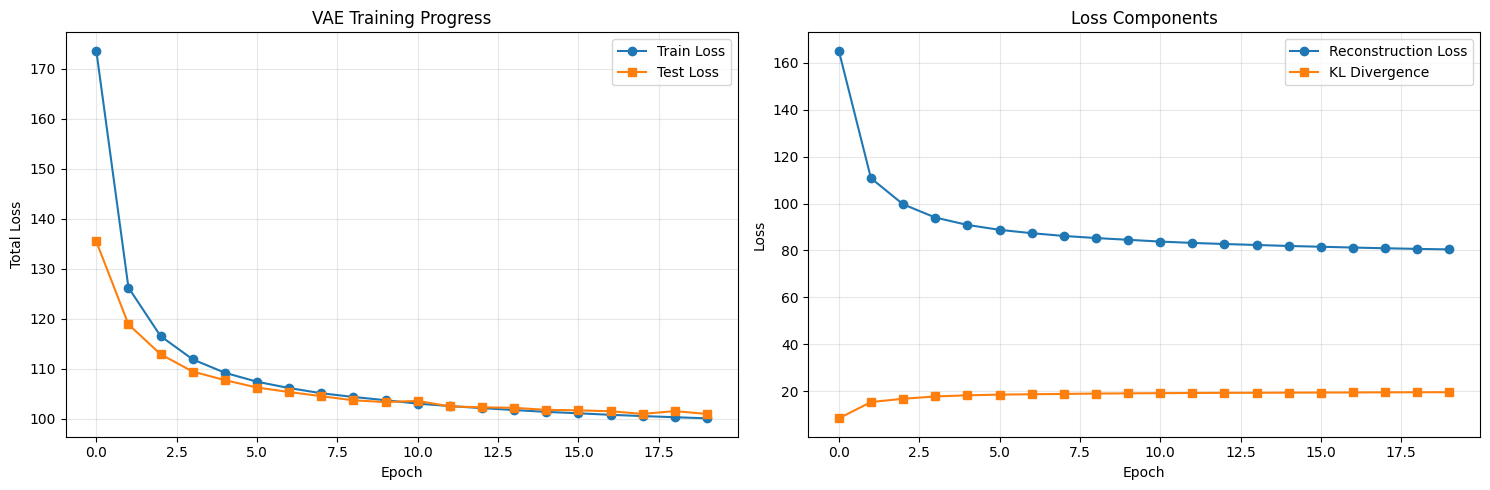

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Total loss
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(test_losses, label='Test Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('VAE Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss components
axes[1].plot(recon_losses, label='Reconstruction Loss', marker='o')
axes[1].plot(kl_losses, label='KL Divergence', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Evaluation & Visualization <a id='evaluation'></a>

Compare original images with their reconstructions.

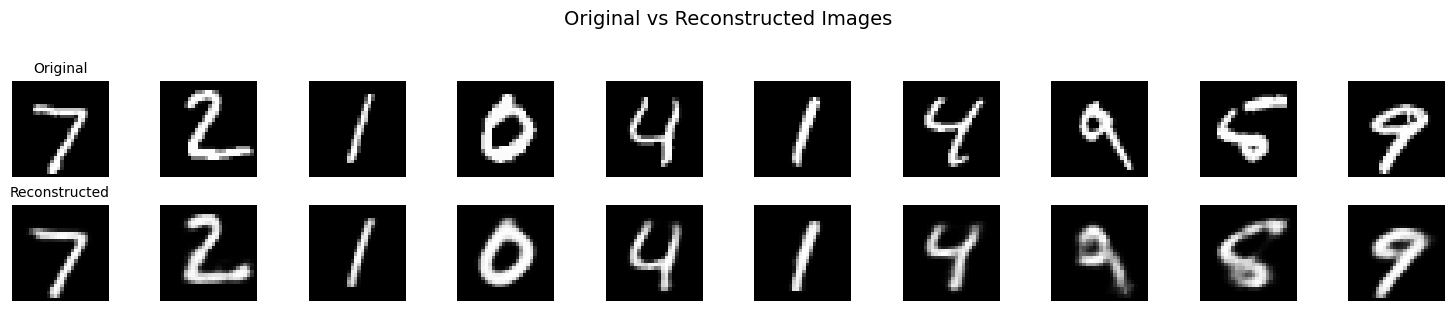

In [10]:
# Get sample images
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    images_flat = images.view(-1, 784)
    reconstructed, _, _ = model(images_flat)
    reconstructed = reconstructed.view(-1, 1, 28, 28)

# Visualize
n_samples = 10
fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))

for i in range(n_samples):
    # Original
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10)

    # Reconstructed
    axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=10)

plt.suptitle('Original vs Reconstructed Images', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Latent Space Exploration <a id='latent'></a>

Visualize the learned latent representations.

In [11]:
# Extract latent representations
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Encoding'):
        images = images.view(-1, 784).to(device)
        mu, _ = model.encode(images)
        latent_vectors.append(mu.cpu().numpy())
        labels_list.append(labels.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

print(f'Latent space shape: {latent_vectors.shape}')

Encoding: 100%|██████████| 79/79 [00:01<00:00, 78.46it/s]

Latent space shape: (10000, 20)


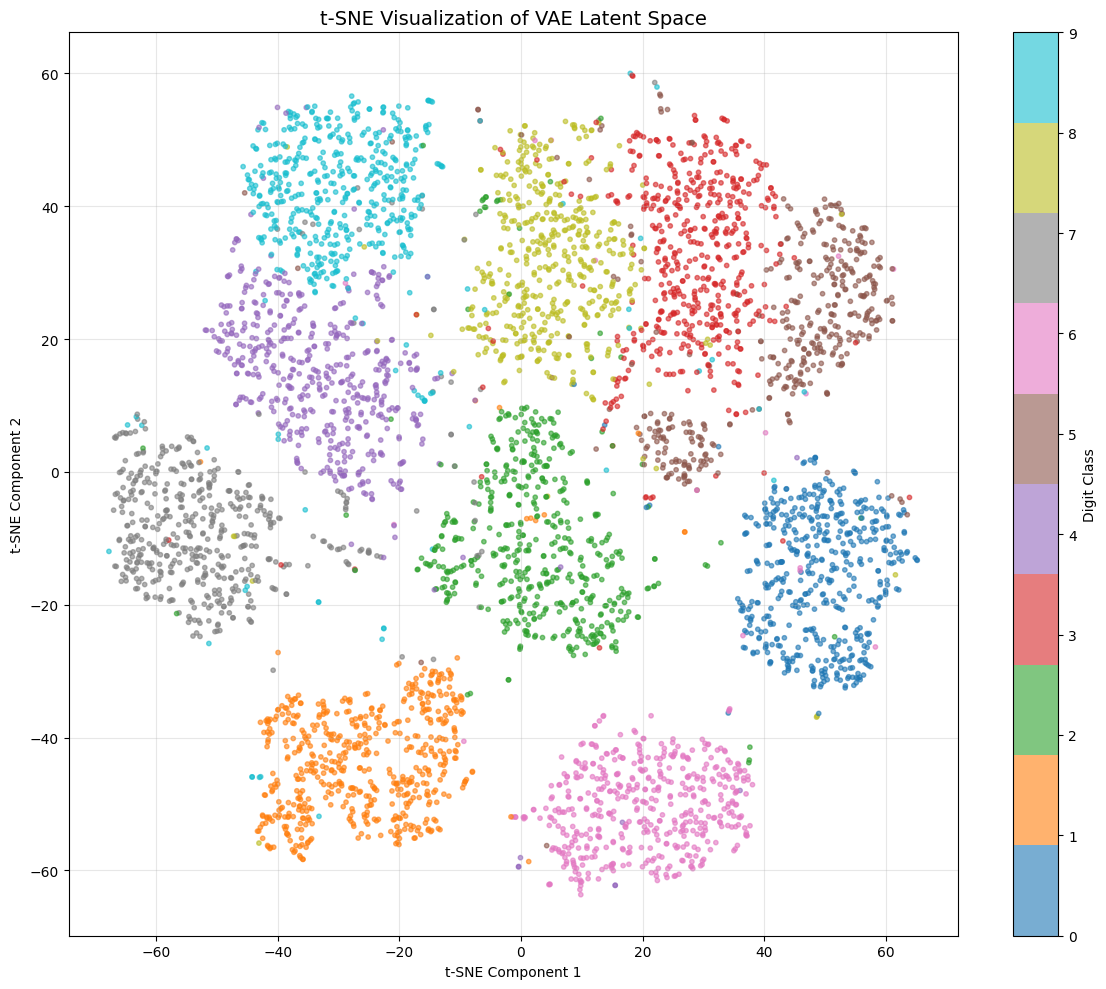

In [12]:
# Apply t-SNE for visualization
n_samples = 5000
indices = np.random.choice(len(latent_vectors), n_samples, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_vectors[indices])

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                     c=labels_array[indices], cmap='tab10',
                     alpha=0.6, s=10)
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of VAE Latent Space', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Image Generation <a id='generation'></a>

Generate new images by sampling from the latent space.

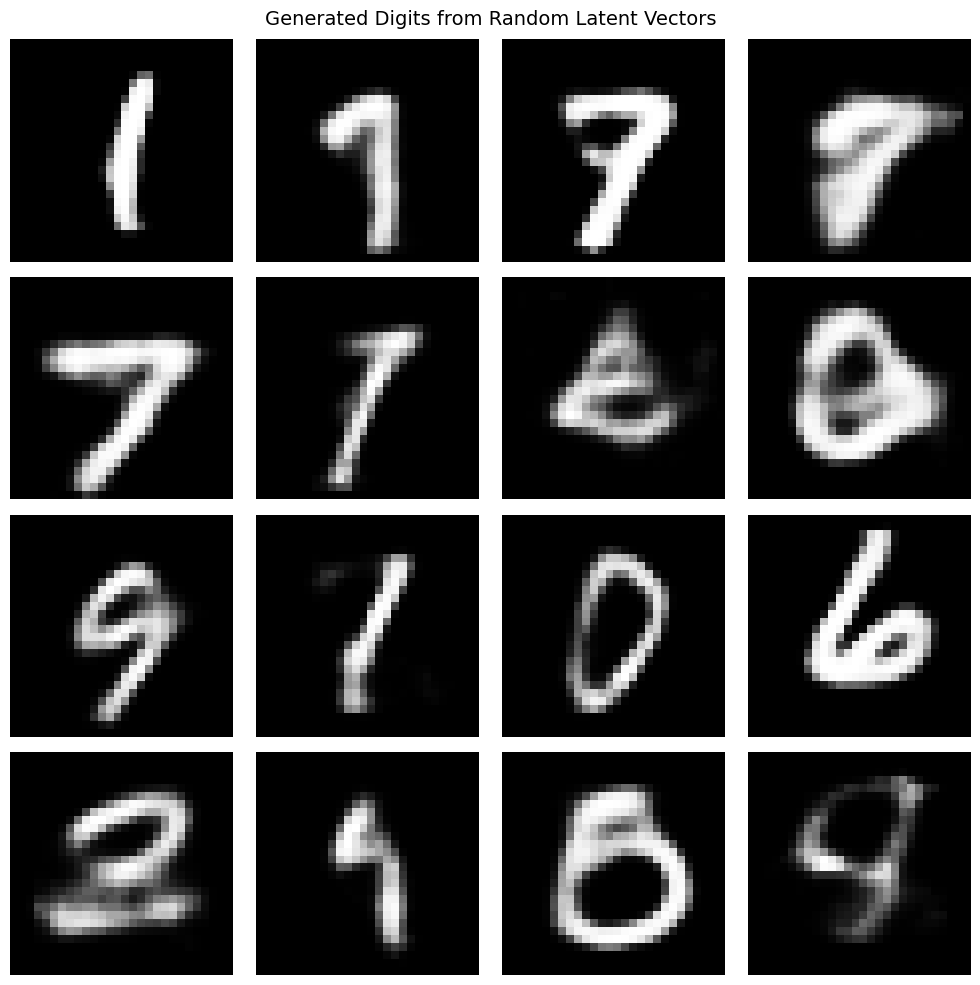

In [13]:
# Generate random samples
model.eval()
with torch.no_grad():
    # Sample from standard normal distribution
    z = torch.randn(16, latent_dim).to(device)
    generated = model.decode(z)
    generated = generated.view(-1, 1, 28, 28)

# Visualize generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.suptitle('Generated Digits from Random Latent Vectors', fontsize=14)
plt.tight_layout()
plt.show()

### Latent Space Interpolation

Interpolate between two latent vectors to see smooth transitions.

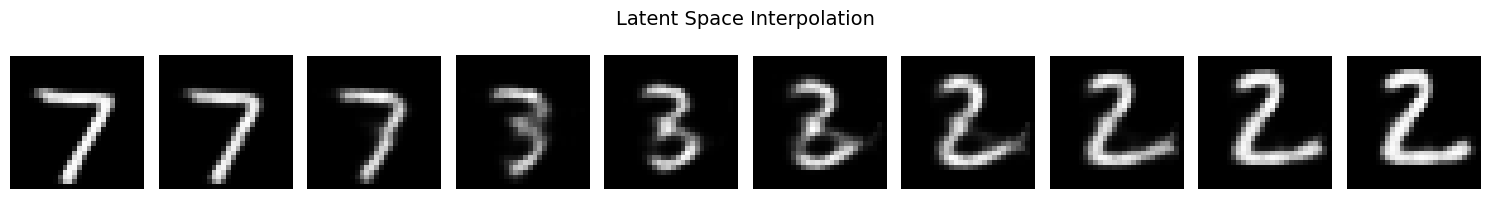

In [14]:
# Select two images
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    img1 = images[0:1].view(-1, 784).to(device)
    img2 = images[1:2].view(-1, 784).to(device)

    # Encode to latent space
    z1, _ = model.encode(img1)
    z2, _ = model.encode(img2)

    # Interpolate
    n_steps = 10
    interpolations = []

    for alpha in np.linspace(0, 1, n_steps):
        z_interp = (1 - alpha) * z1 + alpha * z2
        img_interp = model.decode(z_interp)
        interpolations.append(img_interp.view(28, 28).cpu())

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(interpolations[i], cmap='gray')
    ax.axis('off')

plt.suptitle('Latent Space Interpolation', fontsize=14)
plt.tight_layout()
plt.show()

### 2D Latent Space Manifold

If we train with latent_dim=2, we can visualize the entire latent space as a grid.

/tmp/ipython-input-2203118017.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size: (i + 1) * digit_size,


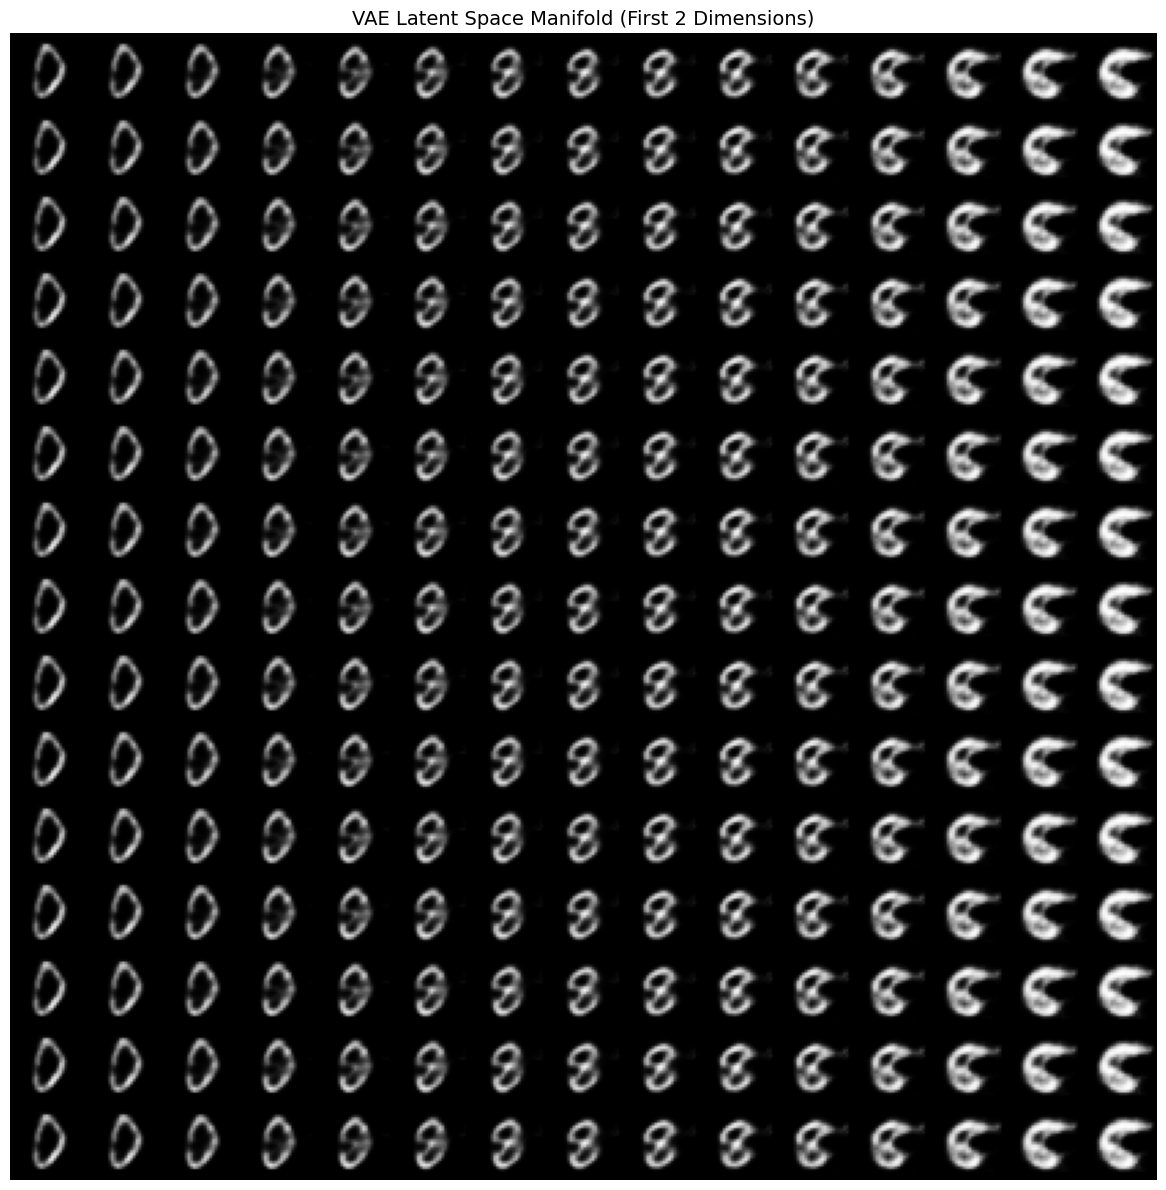

In [15]:
# Generate a grid of latent vectors and decode them
n = 15  # Grid size
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Linearly spaced coordinates on the unit square
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            # If latent_dim > 2, pad with zeros
            if latent_dim > 2:
                z_sample = torch.cat([z_sample, torch.zeros(1, latent_dim-2).to(device)], dim=1)

            x_decoded = model.decode(z_sample)
            digit = x_decoded.cpu().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure, cmap='gray')
plt.title('VAE Latent Space Manifold (First 2 Dimensions)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## Save Model

In [16]:
# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

# Save model
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_losses': recon_losses,
    'kl_losses': kl_losses,
    'latent_dim': latent_dim,
    'num_epochs': num_epochs
}

torch.save(checkpoint, 'checkpoints/vae.pth')
print('Model saved successfully!')

Model saved successfully!
